In [1]:
from new_SiameseNet import *
%matplotlib inline
import matplotlib.pyplot as plt

Using Theano backend.
/Users/wilbury/anaconda/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


In [61]:
# Prepare data
print 'Getting CIFAR10 data...'

'''
data = get_CIFAR10_data()

x_train, y_train = data['X_train'], data['y_train']
x_val,   y_val   = data['X_val'],   data['y_val']
'''

(x_train, y_train), (x_val, y_val) = cifar10.load_data()

x_train = x_train.astype('float32')
x_val = x_val.astype('float32')

y_train = y_train.reshape((y_train.shape[0],))
y_val = y_val.reshape((y_val.shape[0],))

N = x_train.shape[0]

Getting CIFAR10 data...


In [3]:
# Specify structure of Siamese part of SiameseNet
# This part needs to be improved. I'm kind of just using random layers.
init = 'glorot_uniform'
in_shp = (3,32,32)
seq = Sequential()
seq.add(BatchNormalization(epsilon=1e-7,
                            mode=0,
                            axis=1,
                            momentum=0.9,
                            weights=None,
                            input_shape=in_shp))
#seq.add(Flatten())
#seq.add(Dense(128, activation='relu'))
#seq.add(Dropout(0.1))
#seq.add(Dense(128, activation='relu'))
#seq.add(Dropout(0.1))
for _ in range(2):
    seq.add(Convolution2D(3, 3, 3, init=init, border_mode='same'))
    seq.add(Activation('relu'))
    seq.add(Dropout(.1))
#seq.add(Dense(128, activation='relu'))
seq.add(Flatten())
seq.add(Dense(128))
layers = seq

sn = SiameseNet(layers, input_shape=(3, 32, 32), verbose=False)
sn.compile()

In [4]:
def _train_sn(sn, x_train, y_train, x_val, y_val, filepath):
    d_val = invert_dataset(x_val,  y_val)
    d_train = invert_dataset(x_train,  y_train)
    num_ep = 10
    history = sn.fit(*generate_data(x_train, d_train), 
            validation_data=generate_data(x_val, d_val),
            nb_epoch=num_ep)
    return history

history = _train_sn(sn, x_train, y_train, x_val, y_val, filepath='weights.h5')

Train on 97600 samples, validate on 1540 samples
Epoch 1/10
97600/97600 [==============================] - 66s - loss: 0.3157 - val_loss: 0.2359
Epoch 2/10
97600/97600 [==============================] - 65s - loss: 0.2389 - val_loss: 0.2316
Epoch 3/10
97600/97600 [==============================] - 65s - loss: 0.2291 - val_loss: 0.2361
Epoch 4/10
97600/97600 [==============================] - 65s - loss: 0.2227 - val_loss: 0.2250
Epoch 5/10
97600/97600 [==============================] - 65s - loss: 0.2179 - val_loss: 0.2327
Epoch 6/10
97600/97600 [==============================] - 65s - loss: 0.2140 - val_loss: 0.2193
Epoch 7/10
97600/97600 [==============================] - 65s - loss: 0.2105 - val_loss: 0.2187
Epoch 8/10
97600/97600 [==============================] - 65s - loss: 0.2074 - val_loss: 0.2185
Epoch 9/10
97600/97600 [==============================] - 65s - loss: 0.2046 - val_loss: 0.2372
Epoch 10/10
97600/97600 [==============================] - 65s - loss: 0.2027 - val_los

In [5]:
#loss = sn.evaluate(*generate_data(d_val, examples_per_image=5))
d_val = invert_dataset(x_val,  y_val)
val_x_dat, val_y_dat = generate_data(x_val, d_val)
prediction = sn.predict(val_x_dat)[SiameseNet.OUTPUT]

ret_preds = prediction
max_d = np.max(ret_preds)
min_d = np.min(ret_preds)

print max_d
print min_d

#thresh = (max_d + min_d) / 2.0
#preds = [0,0]
#for i,p in enumerate(prediction):
#    if ret_preds[i] > thresh:
#        preds[1] += 1
#    else:
#        preds[0] += 1
#print preds

1.26899111271
0.120806694031


In [6]:
#print history.history
l = history.history['loss']
val_l = history.history['val_loss']

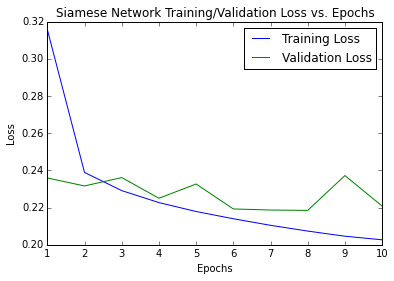

In [7]:
plt.figure()
plt.plot(range(1,len(l)+1), l, label='Training Loss')
plt.title('Siamese Network Training/Validation Loss vs. Epochs')
plt.plot(range(1,len(val_l)+1), val_l, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#plt.savefig('siam_loss3.png')

In [8]:
def similarity(sn, x1, x2):
    x = [np.array([x1]), np.array([x2])]
    prediction = sn.predict(x, batch_size=1)
    return prediction['output'][0][0]

In [9]:
similarity(sn, x_train[0], x_train[1])

0.91613972187042236

In [10]:
num_zeros = 4913
num_ones = 9794 - 4913
num_examples = 80
sorted_index = np.argsort(y_train)[:num_zeros + num_ones]
chosen_zeros = sorted_index[random.sample(xrange(num_zeros), num_examples)]
chosen_ones = sorted_index[random.sample(xrange(num_zeros, num_zeros + num_ones), num_examples)]
indices = np.hstack((chosen_zeros, chosen_ones))
sorted_y_train = y_train[indices]
sorted_x_train = x_train[indices]

In [11]:
num_tests = len(indices)
similarity_matrix = np.zeros((num_tests, num_tests))
for i in xrange(num_tests):
    for j in xrange(num_tests):
        similarity_matrix[i][j] = similarity(sn, sorted_x_train[i], sorted_x_train[j])

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

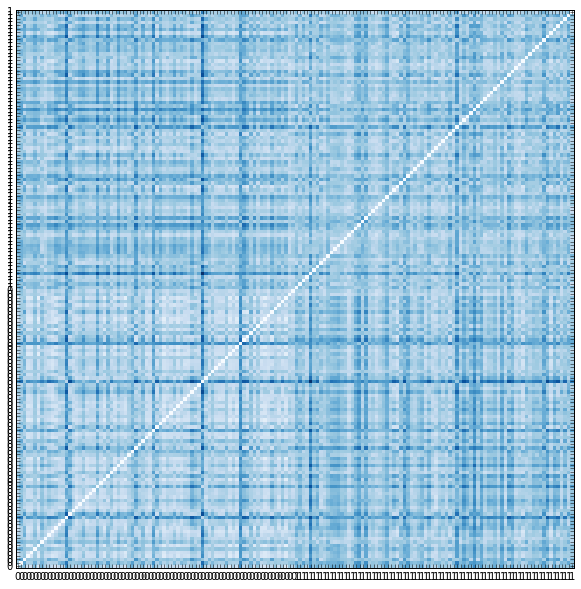

In [18]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
ax.pcolor(similarity_matrix, cmap=matplotlib.cm.Blues)
ax.set_xticks(np.arange(similarity_matrix.shape[0])+0.5, minor=False)
ax.set_yticks(np.arange(similarity_matrix.shape[1])+0.5, minor=False)
ax.set_xticklabels(sorted_y_train, minor=False)
ax.set_yticklabels(sorted_y_train, minor=False)
#plt.savefig('similarity_matrix_80_examples_5.png')

In [19]:
print np.mean(similarity_matrix[0:10:1,0:10:1])
print np.mean(similarity_matrix[10:20:1,10:20:1])
print np.mean(similarity_matrix[0:10:1,10:20:1])
print np.mean(similarity_matrix[10:20:1,0:10:1])

0.368407767128
0.405735358527
0.425017428994
0.425017426759


In [62]:
class KNN:
    def train(self, x, y):
        self.x_train = x
        self.y_train = y
        self.l2_dist = None
        self.siam_dist = None
        
    def compute_l2_dist(self, x_test):
        num_test = x_test.shape[0]
        num_train = self.x_train.shape[0]
        dists = np.zeros((num_test, num_train))
        x_test = x_test.reshape(num_test, -1)
        x_train = self.x_train.reshape(num_train, -1)
        aat = x_test.dot(x_test.T)
        abt = x_test.dot(x_train.T)
        bbt = x_train.dot(x_train.T)
        a2 = np.diag(aat).reshape(1,-1).T
        b2 = np.diag(bbt).reshape(1,-1)
        dists = np.sqrt(a2 - 2*abt + b2)
        self.l2_dists = dists
        
    def compute_siam_dist(self, sn, x_test):
        # x_test should be an array of datapoints
        #print self.x_train.shape
        #print x_test.shape
        num_test = x_test.shape[0]
        num_train = self.x_train.shape[0]
        dists = np.zeros((num_test, num_train))
        predictions = []
        for i in range(num_test):
            cur_samp = x_test[i]
            cur_samp = np.expand_dims(cur_samp, 0)
            cur_im = np.vstack([cur_samp]*num_train)
            x = [cur_im, self.x_train]
            prediction = sn.predict(x, batch_size=num_train)['output'].flatten()
            dists[i,:] = prediction
        self.siam_dists = dists
    
    def predict_k(self, mode='l2', k=1):
        dists = None
        if mode == 'l2':
            dists = self.l2_dists
        else:
            dists = self.siam_dists
        num_test = dists.shape[0]
        predictions = []
        for i in range(num_test):
            k_pred_inds = None
            k_pred_inds = dists[i,:].argsort()[:k]
            k_pred_dists = dists[i,k_pred_inds]
            k_pred_classes = self.y_train[k_pred_inds]
            class_pred = np.argmax(np.bincount(k_pred_classes))
            predictions.append((k_pred_inds, k_pred_dists, k_pred_classes, class_pred))
        return predictions

In [91]:
knn = KNN()
knn.train(x_train[:10000], y_train[:10000])
knn.compute_l2_dist(x_val[:100])

In [97]:
k_acc = []
for k in range(1,50,1):
    print k
    preds = knn.predict_k(k=k)
    num_correct = 0.0
    correct_imgs = []
    incorrect_imgs = []
    for i,pred in enumerate(preds):
        inds, dists, classes, c_pred = pred
        if c_pred == y_val[i]:
            num_correct += 1
            correct_imgs.append((i,pred))
        else:
            incorrect_imgs.append((i,pred))

    acc = num_correct / len(preds)
    k_acc.append((acc, correct_imgs, incorrect_imgs))
    print acc

1
0.3
2
0.23
3
0.32
4
0.32
5
0.37
6
0.35
7
0.33
8
0.32
9
0.36
10
0.36
11
0.36
12
0.38
13
0.37
14
0.38
15
0.38
16
0.38
17
0.37
18
0.36
19
0.36
20
0.37
21
0.35
22
0.33
23
0.33
24
0.33
25
0.33
26
0.33
27
0.33
28
0.32
29
0.31
30
0.3
31
0.31
32
0.31
33
0.32
34
0.31
35
0.32
36
0.32
37
0.31
38
0.32
39
0.31
40
0.3
41
0.31
42
0.31
43
0.31
44
0.31
45
0.31
46
0.29
47
0.29
48
0.31
49
0.29


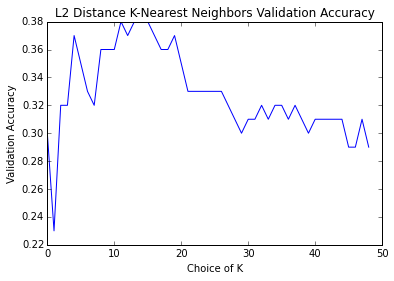

In [98]:
accs = []
for k in range(len(k_acc)):
    acc, _, _ = k_acc[k]
    accs.append(acc)
plt.plot(accs)
plt.title('L2 Distance K-Nearest Neighbors Validation Accuracy')
plt.ylabel('Validation Accuracy')
plt.xlabel('Choice of K')
plt.show()
plt.savefig('l2_knn_val_acc.png')

6
3


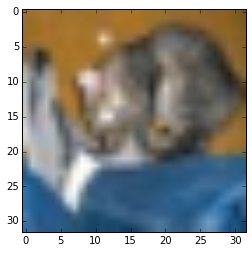

6


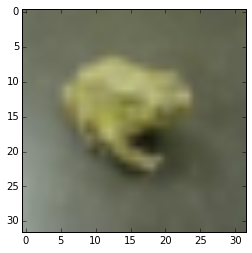

8
0


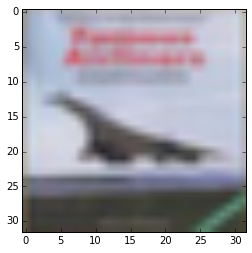

8


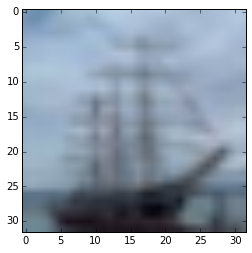

4
6


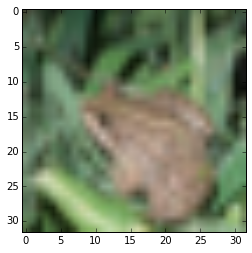

4


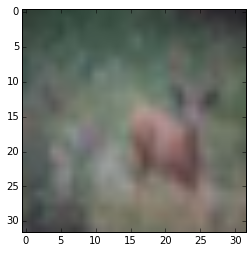

4
6


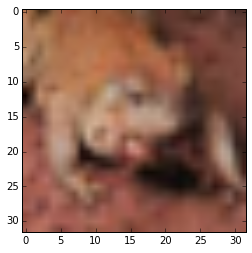

4


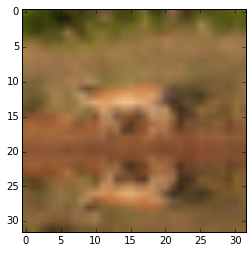

3
1


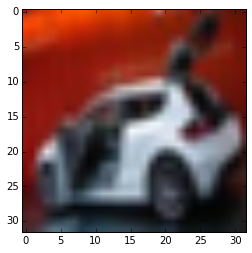

3


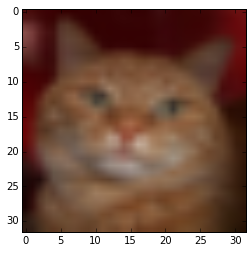

In [99]:
acc, cor_ims, inc_ims = k_acc[0]
trunc_cor_ims = cor_ims[:5]
trunc_inc_ims = inc_ims[:5]
for ind,im in enumerate(trunc_inc_ims):
    i, pred = im
    inds, dists, classes, c_pred = pred
    im1 = x_val[i,:]
    im2 = x_train[inds[0],:]
    im1 = np.rollaxis(im1,0,3).astype('uint8')
    im2 = np.rollaxis(im2,0,3).astype('uint8')
    print c_pred
    print y_val[i]
    plt.imshow(im1)
    plt.show()
    print classes[0]
    plt.imshow(im2)
    plt.show()

best k = 11
38
62


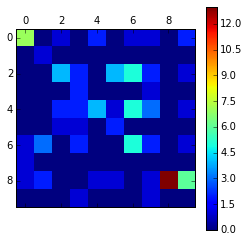

In [100]:
print 'best k =', np.argmax(accs)
acc, cor_ims, inc_ims = k_acc[np.argmax(accs)]
confusion_matrix = np.zeros((10,10))
print len(cor_ims)
print len(inc_ims)
for ind, im in enumerate(cor_ims):
    i, pred = im
    inds, dists, classes, c_pred = pred
    confusion_matrix[c_pred, y_val[i]] += 1
    
for ind, im in enumerate(inc_ims):
    i, pred = im
    inds, dists, classes, c_pred = pred
    confusion_matrix[c_pred, y_val[i]] += 1
    
plt.matshow(confusion_matrix)
plt.colorbar()
plt.savefig('l2_knn_confusion_matrix.png')

In [30]:
s_knn = KNN()
s_knn.train(x_train[:10000], y_train[:10000])
s_knn.compute_siam_dist(sn,x_val[:100])

In [33]:
siam_acc = []
for k in range(1,50,1):
    print k
    preds = s_knn.predict_k(mode='siam',k=k)
    num_correct = 0.0
    correct_imgs = []
    incorrect_imgs = []
    for i,pred in enumerate(preds):
        inds, dists, classes, c_pred = pred
        if c_pred == y_val[i]:
            num_correct += 1
            correct_imgs.append((i,pred))
        else:
            incorrect_imgs.append((i,pred))

    acc = num_correct / len(preds)
    siam_acc.append((acc, correct_imgs, incorrect_imgs))
    print acc

1
0.29
2
0.25
3
0.31
4
0.29
5
0.3
6
0.3
7
0.31
8
0.31
9
0.26
10
0.3
11
0.32
12
0.3
13
0.3
14
0.3
15
0.28
16
0.26
17
0.29
18
0.27
19
0.29
20
0.32
21
0.32
22
0.32
23
0.31
24
0.33
25
0.32
26
0.31
27
0.32
28
0.33
29
0.33
30
0.33
31
0.32
32
0.32
33
0.33
34
0.34
35
0.31
36
0.33
37
0.31
38
0.32
39
0.32
40
0.32
41
0.32
42
0.33
43
0.33
44
0.32
45
0.32
46
0.32
47
0.31
48
0.31
49
0.32


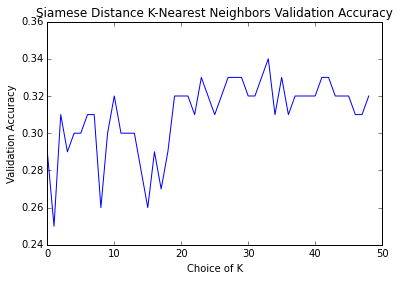

In [34]:
accs = []
for k in range(len(siam_acc)):
    acc, _, _ = siam_acc[k]
    accs.append(acc)
plt.plot(accs)
plt.title('Siamese Distance K-Nearest Neighbors Validation Accuracy')
plt.ylabel('Validation Accuracy')
plt.xlabel('Choice of K')
plt.show()
plt.savefig('siam_knn_val_acc.png')

34
66


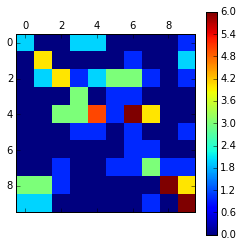

In [35]:
acc, cor_ims, inc_ims = siam_acc[33]
confusion_matrix = np.zeros((10,10))
print len(cor_ims)
print len(inc_ims)
for ind, im in enumerate(cor_ims):
    i, pred = im
    inds, dists, classes, c_pred = pred
    confusion_matrix[c_pred, y_val[i]] += 1
    
for ind, im in enumerate(inc_ims):
    i, pred = im
    inds, dists, classes, c_pred = pred
    confusion_matrix[c_pred, y_val[i]] += 1
    
plt.matshow(confusion_matrix)
plt.colorbar()
plt.savefig('siam_knn_confusion_matrix.png')

4
9


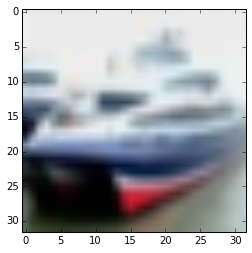

4


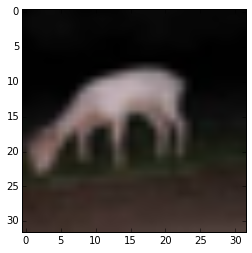

2
4


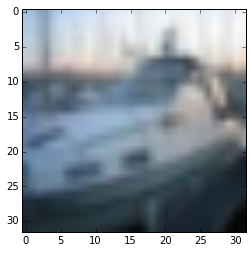

2


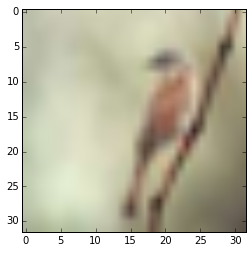

4
9


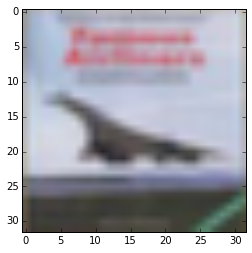

4


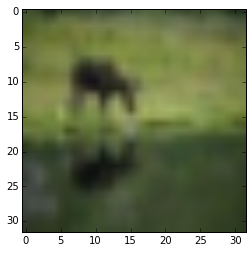

2
5


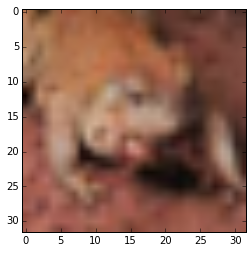

2


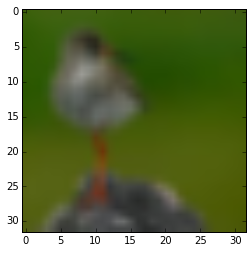

2
7


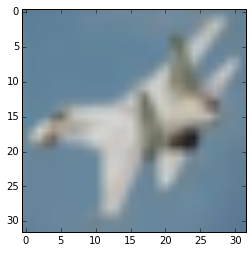

2


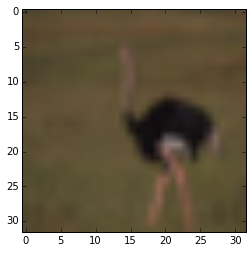

In [36]:
acc, cor_ims, inc_ims = siam_acc[0]
trunc_cor_ims = cor_ims[:5]
trunc_inc_ims = inc_ims[:5]
for ind,im in enumerate(trunc_inc_ims):
    i, pred = im
    inds, dists, classes, c_pred = pred
    im1 = im_x_val[i,:]
    im2 = im_x_train[inds[0],:]
    im1 = np.rollaxis(im1,0,3)
    im2 = np.rollaxis(im2,0,3)
    print c_pred
    print y_val[i]
    plt.imshow(im1)
    plt.show()
    print classes[0]
    plt.imshow(im2)
    plt.show()